---
---
---

# Brain Tumor Segmentation with U-Net 🧩

**Objective**:
Develop and evaluate a resource-efficient U-Net for delineating brain tumor subregions from multi-modal MRI.

---
---
---

---

## 1. Setup 📦

---

In [1]:
# Data Management
import glob
import numpy as np
import pandas as pd

# Data Visualization
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import seaborn as sns
from skimage.transform import rotate

# Computational Modules
import math
from scipy.stats import norm, zscore
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Deep Learning Frameworks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Utils
from collections import defaultdict
import h5py
from google.colab import drive
from IPython.display import display, HTML, IFrame, Image
import os
from pathlib import Path
import random
import re
from tqdm import tqdm

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})


---

## 2. Data Access 📂

---

In [2]:
# Define project root
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define file paths relative to drive structure
data_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data'
meta_data_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data/meta_data.csv'
name_mapping_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data/name_mapping.csv'
survival_info_path = '/content/drive/MyDrive/BraTS_Data/BraTS2020_training_data/content/data/survival_info.csv'
slice_paths = sorted(glob.glob(os.path.join(data_path, '*.h5')))  # get all .h5 files

In [5]:
### TO BE EXECUTED BEFORE TRAINING FOR FULL DATASET ###
### Copy dataset locally and use instead for faster access ###

# !cp -r /content/drive/MyDrive/BraTS_Data /content/
# data_path = '/content/BraTS_Data/BraTS2020_training_data/content/data'
# slice_paths = sorted(glob.glob(os.path.join(data_path, '*.h5')))

---

## 3. Model Prerequisites ⚙️

---

#### **3a. Split imaging data into training and validation sets.**

For this v1 (baseline model), only a limited set of MRI volumes will be used due to runtime trouble on free-tier Colab. Once an entire workflow is established, a more fleshed-out splitting will take place for future versions.

In [7]:
# Extract random patient/volume IDs for baseline model
random.seed(42)
selected_patients = random.sample(range(0, 368), 4)
print('Randomly selected patient IDs: ', selected_patients)

Randomly selected patient IDs:  [327, 57, 12, 140]


In [8]:
# Convert numeric IDs into corresponding filename prefixes
selected_prefixes = [f'volume_{pid}_' for pid in selected_patients]
selected_prefixes

['volume_327_', 'volume_57_', 'volume_12_', 'volume_140_']

In [9]:
# Collect all slices belonging to selected patients
selected_slice_paths = [
    path for path in slice_paths
    if any(prefix in os.path.basename(path) for prefix in selected_prefixes)
]
print('Total selected slices: ', len(selected_slice_paths))
# selected_slice_paths

Total selected slices:  620


In [10]:
# Copy selected slices to local runtime (for faster I/O during training)
local_data_path = '/content/baseline_data'
os.makedirs(local_data_path, exist_ok=True)
for path in selected_slice_paths:
    filename = os.path.basename(path)
    !cp '{path}' '{local_data_path}/{filename}'

In [11]:
# Rebuild slice list from local directory
local_slice_paths = sorted(glob.glob(os.path.join(local_data_path, '*.h5')))
print('Local slice count: ', len(local_slice_paths))

Local slice count:  620


In [12]:
# Group slices by patient (patient-level split)
patient_to_slices = defaultdict(list)
for path in local_slice_paths:
    filename = os.path.basename(path)
    patient_id = filename.split('_slice')[0]
    patient_to_slices[patient_id].append(path)
print(f'Patients found locally: {list(patient_to_slices.keys())}')

Patients found locally: ['volume_12', 'volume_140', 'volume_327', 'volume_57']


In [13]:
# Seperate train and validation patients
patient_ids = list(patient_to_slices.keys())

train_patients = ['volume_' + str(i) for i in selected_patients[:3]]
val_patients = ['volume_' + str(i) for i in selected_patients[3:]]

print('Train patients:', train_patients)
print('Val patient:', val_patients)

Train patients: ['volume_327', 'volume_57', 'volume_12']
Val patient: ['volume_140']


In [14]:
# Separate train and validation slice paths
train_paths = []
val_paths = []

for pid in train_patients:
    train_paths.extend(patient_to_slices[pid])
for pid in val_patients:
    val_paths.extend(patient_to_slices[pid])

print('Train slices:', len(train_paths))
print('Val slices:', len(val_paths))

Train slices: 465
Val slices: 155


**Patient-Level Subset Selection and Split**

To keep training within runtime limits, a small baseline subset was created by randomly selecting four patients (seed = 42). All slices belonging to these patients were identified and copied locally to the Colab runtime to ensure faster disk access during training.

A deterministic 3:1 patient-level split was then applied. The split is performed at the patient level (not slice level) to prevent data leakage, ensuring that no slices from the same volume appear in both sets.

This setup keeps the experiment lightweight while preserving proper evaluation structure.

#### **3b. Format and standardize slices via PyTorch Dataset.**

In [15]:
class BraTSDataset(Dataset):
    """
    PyTorch Dataset for loading 2D BraTS slices stored as .h5 files.

    Each file contains:
        - image: (H, W, 4)
              MRI modalities in order: [T1, T1Gd, T2, T2-FLAIR]
        - mask:  (H, W, 3)
              Binary tumor subregions: [NEC/NET, ED, ET]

    Output format:
        - image tensor: (4, H, W), float32
        - mask tensor:  (3, H, W), float32
    """

    def __init__(self, slice_paths):
        """
        Args:
            slice_paths (list): List of file paths to .h5 slice files.
        """
        self.slice_paths = slice_paths

    def __len__(self):
        """
        Returns total number of slices and enables use with PyTorch DataLoader.
        """
        return len(self.slice_paths)

    def __getitem__(self, idx):
        """
        Loads and processes a single slice from disk.

        Steps:
            1. Load image + mask from disk (lazy loading)
            2. Convert to float32 (memory + GPU compatible)
            3. Apply per-slice, per-modality z-score normalization
            3. Rearrange to channel-first format (C, H, W) for PyTorch
            4. Convert to torch.Tensor
        """

        file_path = self.slice_paths[idx]

        # Load slice from disk (lazy loading; no full dataset in memory)
        with h5py.File(file_path, 'r') as file:
            image = file['image'][:]   # Shape: (H, W, 4)
            mask  = file['mask'][:]    # Shape: (H, W, 3)

        # Ensure correct dtype for training (convert to float32)
        image = image.astype(np.float32)
        mask  = mask.astype(np.float32)  # Also converted for loss computation; Binary values for each tumor subregion

        # Per-slice & per-modality z-score normalization to standardize intensity dist. independently for each MRI modality channel
        for c in range(image.shape[-1]):
            channel = image[:, :, c]
            mean = channel.mean()
            std = channel.std()
            if std > 0:
                image[:, :, c] = (channel - mean) / std  # Improves optimization stability and handles inter-patient intensity variation
            else:
                image[:, :, c] = channel - mean  # Avoid division by zero if std=0

        # Convert to channel-first format (C, H, W) (required for PyTorch Conv2D layers)
        image = np.transpose(image, (2, 0, 1))  # (4, H, W)
        mask  = np.transpose(mask, (2, 0, 1))   # (3, H, W)

        # Convert numpy arrays to torch tensors
        image_tensor = torch.from_numpy(image)
        mask_tensor  = torch.from_numpy(mask)

        return image_tensor, mask_tensor

In [16]:
# Implement processing steps onto train and validation sets
train_dataset = BraTSDataset(train_paths)
val_dataset   = BraTSDataset(val_paths)

In [17]:
# Inspect example output
sample_img, sample_mask = train_dataset[0]
print('Image shape:', sample_img.shape)   # (4, 240, 240)
print('Mask shape:', sample_mask.shape)   # (3, 240, 240)
print('Image dtype:', sample_img.dtype)
print('Mask dtype:', sample_mask.dtype)

Image shape: torch.Size([4, 240, 240])
Mask shape: torch.Size([3, 240, 240])
Image dtype: torch.float32
Mask dtype: torch.float32


**Dataset Implementation**:

Before training, MRI slices must be properly formatted and standardized to ensure consistent numerical representation, improve training stability, and enable efficient batch loading for the U-Net.

A custom PyTorch `Dataset` class is defined to load individual 2D slices stored as *.h5* files. Each file contains a 4-channel MRI image (T1, T1Gd, T2, T2-FLAIR) and a 3-channel binary segmentation mask representing tumor subregions.

Data is loaded lazily within `__getitem__`, meaning slices are read from disk only when needed. This avoids loading the entire dataset into memory and keeps the pipeline scalable.

Images and masks are converted to *float32* for GPU compatibility and reduced memory usage. Each MRI modality channel is also z-score normalized per slice to standardize intensities and stabilize training. This should improve model convergence and help the network learn more effectively. The arrays are then rearranged to channel-first format **(C, H, W)**, which is required by PyTorch convolutional layers. A sample output was generated to inspect it for expected format.

This design separates data handling from modeling logic, making the pipeline modular, extensible, and ready for the U-Net baseline.

#### **3c. Create DataLoaders for batching and training.**

The next step is to set up data generators to produce iterable batches for training and validation.

In [18]:
# Configure batch size based on v1 constrainsts (GPU + slice size)
batch_size = 4

In [19]:
# Create DataLoaders to handles batching, shuffling, parallel loading, and GPU memory pinning
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,            # shuffle training slices each epoch (ensures SGD sees slices in different order each epoch)
    num_workers=2,           # parallel data loading; adjust based on Colab memory / CPU
    pin_memory=True          # speeds up transfers to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,            # maintain deterministic order (i.e., no shuffle) for validation
    num_workers=2,
    pin_memory=True
)

In [20]:
sample_images, sample_masks = next(iter(train_loader))
print('Batch image shape:', sample_images.shape)  # (B, 4, H, W)
print('Batch mask shape: ', sample_masks.shape)   # (B, 3, H, W)

Batch image shape: torch.Size([4, 4, 240, 240])
Batch mask shape:  torch.Size([4, 3, 240, 240])


**DataLoader Implementation**:

With the Dataset class defined, we now set up PyTorch `DataLoader` to efficiently batch and serve slices during training and validation.

- **Training DataLoader**: shuffles slices each epoch to provide stochasticity for gradient descent, uses multiple workers for parallel loading, and pins memory for faster GPU transfer.
- **Validation DataLoader**: does not shuffle to maintain deterministic evaluation order but still benefits from batching and parallel loading.

Inspecting a sample batch image and mask shape confirms that each batch has the expected shape: images **(B, 4, H, W)** and masks **(B, 3, H, W)**. This ensures that data is correctly formatted, normalized, and ready for input into a segmentation model.

---

## 4. Model Architecture 🏗️

---

Now that the data is preprocessed and loaded in batches, the next step is to define the neural network. A **U-Net** will be used as it is specifically designed for image segmentation.

- U-Net takes an input image (here, 4 MRI channels) and outputs a segmentation mask (here, 3 channels for necrotic core, edema, enhancing tumor).
- It has a **downsampling path** that captures context and an **upsampling path** that recovers spatial details.
- The network will learn, for each pixel, whether it belongs to background or one of the tumor sub-regions.

This setup allows the model to predict multi-class masks directly from MRI slices.

#### **4a. Define a baseline U-Net for brain tumor segmentation.**

In [21]:
class LeanUNet(nn.Module):
    """
    U-Net (v1) for multi-class 2D brain tumor segmentation.

    Input: 4-channel MRI slice (T1, T1Gd, T2, T2-FLAIR)
    Output: 3-channel segmentation mask (Necrotic Core, Edema, Enhancing Tumor)
    """


    def __init__(self, in_channels=4, out_channels=3, init_features=16):
        super(LeanUNet, self).__init__()
        features = init_features

        ### Encoder (downsampling path)
        self.encoder1 = self._conv_block(in_channels, features)
        self.pool1    = nn.MaxPool2d(2)

        self.encoder2 = self._conv_block(features, features*2)
        self.pool2    = nn.MaxPool2d(2)

        self.encoder3 = self._conv_block(features*2, features*4)
        self.pool3    = nn.MaxPool2d(2)

        ### Bottleneck
        self.bottleneck = self._conv_block(features*4, features*8)

        #### Decoder (upsampling path)
        self.upconv3 = nn.ConvTranspose2d(features*8, features*4, kernel_size=2, stride=2)
        self.decoder3 = self._conv_block(features*8, features*4)

        self.upconv2 = nn.ConvTranspose2d(features*4, features*2, kernel_size=2, stride=2)
        self.decoder2 = self._conv_block(features*4, features*2)

        self.upconv1 = nn.ConvTranspose2d(features*2, features, kernel_size=2, stride=2)
        self.decoder1 = self._conv_block(features*2, features)

        ### Output layer
        self.conv_final = nn.Conv2d(features, out_channels, kernel_size=1)


    def forward(self, x):
        ### Encoder forward pass
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        ### Bottleneck
        bottleneck = self.bottleneck(self.pool3(enc3))

        ### Decoder forward pass with skip connections
        dec3 = self.upconv3(bottleneck)  # upsample
        dec3 = torch.cat((dec3, enc3), dim=1)  # concatenate skip connection from encoder
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        ### Output
        return self.conv_final(dec1)


    ### 2-conv block
    def _conv_block(self, in_channels, out_channels):
        """
        Standard double-convolution block:
            Conv2d -> ReLU -> Conv2d -> ReLU
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

In [22]:
# Define computation mode
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: ', device)

# Instantiate model
model = LeanUNet().to(device)
# print(model)

# Check output shape for an example batch (will be consolidated later as unit test modules)
ex_input = torch.randn(2, 4, 240, 240).to(device)
ex_output = model(ex_input)
print('Example output shape:', ex_output.shape)  # Expected: (2, 3, 240, 240)

Device:  cuda
Example output shape: torch.Size([2, 3, 240, 240])


**U-Net Architecture**:

- **DoubleConv block**: Two consecutive convolution layers with ReLU activation capture local features efficiently.  
- **Downsampling path**: `DoubleConv + MaxPool` layers reduce spatial dimensions while increasing feature depth, learning contextual information.  
- **Bottleneck**: The deepest layer with the highest feature dimension, capturing the most abstract representation of the input.  
- **Upsampling path**: Transposed convolutions increase spatial resolution, and skip connections concatenate features from the corresponding downsampling layers to recover fine details.  
- **Output layer**: A 1×1 convolution maps features to `out_ch` channels (3 tumor classes).

**Input / Output**:

- **Input**: (C=4, H=240, W=240) MRI slice with four modalities (T1, T1Gd, T2, T2-FLAIR).  
- **Output**: (C=3, H=240, W=240) multi-class segmentation mask, one channel per tumor sub-region.

This design allows the model to predict spatially precise tumor regions while leveraging both global context and local details.


#### **4b. Specify loss function for multi-class segmentation.**


In [23]:
class DiceLoss(nn.Module):
    """
    Computes Dice Loss for multi-channel segmentation.
    Handles multi-label targets with one channel per class.
    """

    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # Predictions and Targets: (B, C, H, W)
        preds = torch.sigmoid(preds)  # Ensure outputs in [0,1]
        intersection = (preds * targets).sum(dim=(2,3))
        union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()  # 1 - mean Dice across batch and channels

In [24]:
# Instantiate loss function
criterion = DiceLoss()

# Inspect with sample tensors (will be consolidated later as unit test modules)
ex_preds = torch.randn(2, 3, 240, 240).to(device)
ex_targets = torch.randint(0, 2, (2, 3, 240, 240)).float().to(device)
loss = criterion(ex_preds, ex_targets)
print('Sample Dice loss: ', loss.item())

Sample Dice loss:  0.4996536374092102


**Loss Function for Multi-Class Segmentation**:

Brain tumor segmentation exhibits extreme class imbalance, with most pixels belonging to healthy tissue / background. Dice Loss is well-suited for this scenario, as it directly measures the overlap between predicted and ground-truth masks.

- **Multi-channel Dice Loss**: Computed independently per tumor sub-region, then averaged.  
- **Sigmoid activation**: Converts raw logits to probabilities in [0,1] for each channel.  
- **Smooth term**: Prevents division by zero when a class is absent in a slice.

This ensures the model learns to capture small, clinically relevant tumor regions rather than being dominated by background pixels. Combining Dice Loss with standard binary cross-entropy can also stabilize training for future versions.

#### **4c. Configure optimizer and learning rate scheduler.**


In [25]:
# Configure Adam optimizer (adaptive learning rates, fast convergence)
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
# Set up LR scheduler to reduce LR if validation Dice plateaus (help convergences)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # maximize validation Dice
    factor=0.5,           # reduce LR by half
    patience=3,           # wait 3 epochs without improvement
)

In [27]:
print('Optimizer parameters count: ', sum(p.numel() for p in model.parameters()))

Optimizer parameters count:  482915


**Optimizer and Learning Rate Scheduler**:

- **Optimizer**: Adam is chosen for its adaptive learning rate capabilities and fast convergence, which is suitable for small baseline datasets.  
- **Learning rate**: Initialized at 1e-3, balancing stability and speed of convergence.  
- **Scheduler**: `ReduceLROnPlateau` monitors validation Dice; if no improvement occurs for 3 epochs, the learning rate is halved to encourage further optimization.

This setup provides a flexible and efficient optimization loop for training the baseline U-Net without manual LR tuning.

#### **4d. Define validation Dice evaluation.**


In [28]:
def compute_dice(preds, targets, threshold=0.5, smooth=1e-6):
    """
    Compute per-channel and mean Dice coefficient for multi-label masks.

    Args:
        preds (torch.Tensor): Model outputs (B, C, H, W) raw logits.
        targets (torch.Tensor): Ground-truth masks (B, C, H, W) in {0,1}.
        threshold (float): Sigmoid threshold to binarize predictions.
        smooth (float): Small value to avoid division by zero.

    Returns:
        dice_per_channel (list of float): Dice for each mask channel.
        mean_dice (float): Average Dice across channels.
    """

    # Apply sigmoid and binarize
    preds = torch.sigmoid(preds) > threshold

    # Flatten spatial dimensions
    preds_flat = preds.view(preds.size(0), preds.size(1), -1).float()
    targets_flat = targets.view(targets.size(0), targets.size(1), -1).float()

    # Compute intersection and union per channel
    intersection = (preds_flat * targets_flat).sum(dim=2)
    union = preds_flat.sum(dim=2) + targets_flat.sum(dim=2)

    # Dice per channel for each sample
    dice = (2 * intersection + smooth) / (union + smooth)

    # Average over batch
    dice_per_channel = dice.mean(dim=0).cpu().tolist()
    mean_dice = dice.mean().item()

    return dice_per_channel, mean_dice

**Validation Dice Evaluation**:

This function computes Dice scores for multi-label segmentation:

- **Per-channel Dice**: Calculates Dice for each tumor sub-region independently.  
- **Mean Dice**: Average across all channels to summarize overall performance.  
- **Binarization**: Predictions are converted from raw logits to 0/1 using a sigmoid threshold (default 0.5).  
- **Batch-wise averaging**: Dice is first computed per slice, then averaged over the batch.

This helper allows efficient evaluation of model performance on the validation set at the end of each epoch or after training without adding significant compute overhead.

In [29]:
def compute_precision_recall(preds, targets, eps=1e-6):
    """
    Compute per-channel precision and recall.
    preds: torch.Tensor (B, C, H, W), binary
    targets: torch.Tensor (B, C, H, W), binary
    eps: small value to avoid division by zero
    """
    C = targets.shape[1]
    precision = []
    recall = []

    for c in range(C):
        pred_c = preds[:, c].flatten()
        target_c = targets[:, c].flatten()

        TP = (pred_c * target_c).sum().float()
        FP = ((pred_c == 1) & (target_c == 0)).sum().float()
        FN = ((pred_c == 0) & (target_c == 1)).sum().float()

        precision.append((TP / (TP + FP + eps)).item())
        recall.append((TP / (TP + FN + eps)).item())

    return precision, recall

#### **4e. Set up remaining training parameters.**


In [30]:
# Training parameters
num_epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move model to device (GPU or CPU)
model.to(device)

print(f'Training is set up to run on {device} for {num_epochs} epochs with batch size {batch_size}.')

Training is set up to run on cuda for 50 epochs with batch size 4.


The baseline U-Net, loss function, optimizer, scheduler, and training parameters are now fully defined. The model is moved to GPU if available for faster computation. **DiceLoss** handles each mask channel as an independent binary label, making it ideal for multi-label segmentation. The **Adam optimizer** provides adaptive learning rates for efficient convergence. `num_epochs` sets how many times the dataset is seen during training, and `batch_size` controls memory usage and gradient stability. With all components in place, the model is ready for training in the next section.

---

## 5. Model Training 🤖

---

In [31]:
# Set up path for checkpoint saves
drive_models_path = '/content/drive/MyDrive/modelsv1'
os.makedirs(drive_models_path, exist_ok=True)

print('Checkpoints will be saved to: ', drive_models_path)

Checkpoints will be saved to:  /content/drive/MyDrive/modelsv1



For each batch, the process is as follows:

Feed MRI slices into the model --> Compute predictions --> Calculate loss --> Backpropagate --> Update weights.  The loss will be tracked over epochs to see if the model is learning.

In [32]:
# Instantiate an empty dataframe to capture metrics during training
metrics_df = pd.DataFrame(columns=[
    'epoch', 'train_loss', 'val_loss', 'mean_dice',
    'dice_NEC/NET', 'dice_ED', 'dice_ET',
    'prec_NEC/NET', 'prec_ED', 'prec_ET',
    'recall_NEC/NET', 'recall_ED', 'recall_ET'
])

In [33]:
for epoch in range(1, num_epochs+1):

    # -------------------------------
    # Training Phase
    # -------------------------------
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f'Epoch {epoch} [Train]'):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()             # Reset gradients
        outputs = model(images)           # Forward pass
        loss = criterion(outputs, masks)  # Dice loss
        loss.backward()                   # Backpropagate
        optimizer.step()                  # Update weights

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)  # Average over all slices

    # -------------------------------
    # Checkpoint Save
    # -------------------------------
    checkpoint_path = os.path.join(drive_models_path, f'v1_epoch_{epoch}.pt')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss,
    }, checkpoint_path)
    print(f'Checkpoint saved: {checkpoint_path}')

    # -------------------------------
    # Validation Phase
    # -------------------------------
    model.eval()
    val_loss = 0.0
    dice_accum = []
    precision_accum = []
    recall_accum = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f'Epoch {epoch} [Val]'):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            # Compute Dice per channel
            dice_ch, mean_dice = compute_dice(outputs, masks)
            dice_accum.append(dice_ch)

            # Compute precision & recall per channel
            prec, rec = compute_precision_recall(preds, masks)
            precision_accum.append(prec)
            recall_accum.append(rec)

            # Accumulate validation loss
            val_loss += criterion(outputs, masks).item() * images.size(0)

    # Average metrics across batches
    val_loss /= len(val_loader.dataset)
    dice_avg = [sum(col)/len(col) for col in zip(*dice_accum)]
    mean_dice_avg = sum(dice_avg)/len(dice_avg)
    precision_avg = [sum(col)/len(col) for col in zip(*precision_accum)]
    recall_avg = [sum(col)/len(col) for col in zip(*recall_accum)]

    # -------------------------------
    # Scheduler Step
    # -------------------------------
    scheduler.step(mean_dice_avg)  # Adjust LR based on validation Dice

    # -------------------------------
    # Epoch Summary
    # -------------------------------
    print(f'Epoch: {epoch} | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Mean Dice: {mean_dice_avg:.4f} | '
          f'Dice per channel: {dice_avg} | '
          f'Precision per channel: {precision_avg} | '
          f'Recall per channel: {recall_avg}')

    # -------------------------------
    # Log metrics into DataFrame
    # -------------------------------
    metrics_df.loc[len(metrics_df)] = [
        epoch, train_loss, val_loss, mean_dice_avg,
        dice_avg[0], dice_avg[1], dice_avg[2],
        precision_avg[0], precision_avg[1], precision_avg[2],
        recall_avg[0], recall_avg[1], recall_avg[2]
    ]

Epoch 1 [Train]: 100%|██████████| 117/117 [00:05<00:00, 20.25it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_1.pt


Epoch 1 [Val]: 100%|██████████| 39/39 [00:02<00:00, 14.77it/s]


Epoch: 1 | Train Loss: 0.9747 | Val Loss: 0.9735 | Mean Dice: 0.2190 | Dice per channel: [0.00642317649473109, 0.41000868771929516, 0.24052215221189485] | Precision per channel: [0.003217998181636899, 0.2204334419220686, 0.058048043137368485] | Recall per channel: [0.40044716993967694, 0.4727748128084036, 0.3733168274928362]


Epoch 2 [Train]: 100%|██████████| 117/117 [00:05<00:00, 19.82it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_2.pt


Epoch 2 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.95it/s]


Epoch: 2 | Train Loss: 0.9441 | Val Loss: 0.9179 | Mean Dice: 0.2726 | Dice per channel: [0.22642445005174108, 0.290858790157252, 0.30052176200126507] | Precision per channel: [0.05028730712066858, 0.2575147732710227, 0.04131837248897705] | Recall per channel: [0.35131285053033096, 0.4437086780865987, 0.16601400535840255]


Epoch 3 [Train]: 100%|██████████| 117/117 [00:06<00:00, 18.25it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_3.pt


Epoch 3 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.87it/s]


Epoch: 3 | Train Loss: 0.9201 | Val Loss: 0.9039 | Mean Dice: 0.2980 | Dice per channel: [0.14591047893690456, 0.34059173587391595, 0.40742495861413736] | Precision per channel: [0.015984166965772133, 0.2990922487508028, 0.15834658282200018] | Recall per channel: [0.30216093093920976, 0.3850219448407491, 0.28028868559079295]


Epoch 4 [Train]: 100%|██████████| 117/117 [00:05<00:00, 22.12it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_4.pt


Epoch 4 [Val]: 100%|██████████| 39/39 [00:01<00:00, 21.89it/s]


Epoch: 4 | Train Loss: 0.8957 | Val Loss: 0.9171 | Mean Dice: 0.3614 | Dice per channel: [0.24040236276368093, 0.28908730663235055, 0.5545794638762098] | Precision per channel: [0.007016861981425721, 0.2915958558710722, 0.0016377501380749238] | Recall per channel: [0.03963777133956169, 0.3036018075087132, 0.005525338726165967]


Epoch 5 [Train]: 100%|██████████| 117/117 [00:06<00:00, 16.97it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_5.pt


Epoch 5 [Val]: 100%|██████████| 39/39 [00:01<00:00, 24.15it/s]


Epoch: 5 | Train Loss: 0.8824 | Val Loss: 0.8767 | Mean Dice: 0.2472 | Dice per channel: [0.21417924049841813, 0.21673045299774635, 0.3107881779723189] | Precision per channel: [0.04097661189734936, 0.25915423570535123, 0.12535998635949233] | Recall per channel: [0.4101609725218553, 0.27257058024406433, 0.4089871324025668]


Epoch 6 [Train]: 100%|██████████| 117/117 [00:05<00:00, 20.50it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_6.pt


Epoch 6 [Val]: 100%|██████████| 39/39 [00:02<00:00, 19.32it/s]


Epoch: 6 | Train Loss: 0.8639 | Val Loss: 0.8317 | Mean Dice: 0.3091 | Dice per channel: [0.07440671455321708, 0.23175377057859634, 0.621219183995698] | Precision per channel: [0.04012889596812714, 0.24624417435664397, 0.27092703985862243] | Recall per channel: [0.38911650425348526, 0.30321370103420353, 0.37030303936738235]


Epoch 7 [Train]: 100%|██████████| 117/117 [00:05<00:00, 22.26it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_7.pt


Epoch 7 [Val]: 100%|██████████| 39/39 [00:01<00:00, 24.06it/s]


Epoch: 7 | Train Loss: 0.8557 | Val Loss: 0.8477 | Mean Dice: 0.2865 | Dice per channel: [0.24047945955230218, 0.25975000719648417, 0.35912734894312986] | Precision per channel: [0.050613705116586805, 0.30556602919330966, 0.12706531770527363] | Recall per channel: [0.41018767540271467, 0.30034995766786426, 0.40997665662031907]


Epoch 8 [Train]: 100%|██████████| 117/117 [00:06<00:00, 16.83it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_8.pt


Epoch 8 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.71it/s]


Epoch: 8 | Train Loss: 0.8555 | Val Loss: 0.8375 | Mean Dice: 0.2312 | Dice per channel: [0.0709902439034386, 0.2590436238560355, 0.3636576362796401] | Precision per channel: [0.03330843493294639, 0.2501852141502194, 0.17383611192687964] | Recall per channel: [0.4091191245959355, 0.38527873425911635, 0.40577114239717144]


Epoch 9 [Train]: 100%|██████████| 117/117 [00:05<00:00, 22.80it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_9.pt


Epoch 9 [Val]: 100%|██████████| 39/39 [00:02<00:00, 14.93it/s]


Epoch: 9 | Train Loss: 0.8460 | Val Loss: 0.8152 | Mean Dice: 0.3656 | Dice per channel: [0.24775643163262337, 0.2780694463195746, 0.5710575701326255] | Precision per channel: [0.061695231888920836, 0.3092032380593129, 0.20389280792994377] | Recall per channel: [0.4027042251366835, 0.3309914469718933, 0.3965433499751947]


Epoch 10 [Train]: 100%|██████████| 117/117 [00:05<00:00, 22.23it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_10.pt


Epoch 10 [Val]: 100%|██████████| 39/39 [00:01<00:00, 24.64it/s]


Epoch: 10 | Train Loss: 0.8436 | Val Loss: 0.8078 | Mean Dice: 0.4613 | Dice per channel: [0.2409726654572468, 0.43188042384208697, 0.7109218867548414] | Precision per channel: [0.047620262326792076, 0.33961204362985414, 0.23220450889605743] | Recall per channel: [0.35375488415742534, 0.311630374346024, 0.3737562589156322]


Epoch 11 [Train]: 100%|██████████| 117/117 [00:06<00:00, 16.83it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_11.pt


Epoch 11 [Val]: 100%|██████████| 39/39 [00:01<00:00, 22.44it/s]


Epoch: 11 | Train Loss: 0.8351 | Val Loss: 0.8191 | Mean Dice: 0.4232 | Dice per channel: [0.271090717144755, 0.4093885538479228, 0.5892361624991156] | Precision per channel: [0.06672067663226372, 0.2916692743698756, 0.20943851081224588] | Recall per channel: [0.387352038652469, 0.30419586789913666, 0.3890804602549626]


Epoch 12 [Train]: 100%|██████████| 117/117 [00:05<00:00, 22.00it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_12.pt


Epoch 12 [Val]: 100%|██████████| 39/39 [00:02<00:00, 15.75it/s]


Epoch: 12 | Train Loss: 0.8331 | Val Loss: 0.8114 | Mean Dice: 0.3985 | Dice per channel: [0.1093350778213756, 0.40165277626992757, 0.6845549722408489] | Precision per channel: [0.04620465299544426, 0.3416441317934256, 0.2389765916726528] | Recall per channel: [0.3678221656725957, 0.2626314667555002, 0.38060397673875856]


Epoch 13 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.63it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_13.pt


Epoch 13 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.63it/s]


Epoch: 13 | Train Loss: 0.8287 | Val Loss: 0.8065 | Mean Dice: 0.4470 | Dice per channel: [0.2660969227081722, 0.40216323946687804, 0.6728641049800607] | Precision per channel: [0.06921091073980698, 0.32061251023641, 0.2475396150197738] | Recall per channel: [0.353123399691704, 0.2772850058017633, 0.3633426275008764]


Epoch 14 [Train]: 100%|██████████| 117/117 [00:06<00:00, 16.82it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_14.pt


Epoch 14 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.31it/s]


Epoch: 14 | Train Loss: 0.8241 | Val Loss: 0.7956 | Mean Dice: 0.5504 | Dice per channel: [0.43443232420279454, 0.5200026947480058, 0.6966515234244497] | Precision per channel: [0.08118926600003853, 0.35982536543638277, 0.2444667529601317] | Recall per channel: [0.2669678360987932, 0.3346648124548105, 0.3377221379524622]


Epoch 15 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.85it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_15.pt


Epoch 15 [Val]: 100%|██████████| 39/39 [00:02<00:00, 14.25it/s]


Epoch: 15 | Train Loss: 0.8204 | Val Loss: 0.8084 | Mean Dice: 0.6327 | Dice per channel: [0.5586444388520185, 0.6061450060357085, 0.7333108014228338] | Precision per channel: [0.1446418040073835, 0.4015200382623917, 0.25485176000839627] | Recall per channel: [0.19093554810835764, 0.2680118252069522, 0.28585160619173294]


Epoch 16 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.85it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_16.pt


Epoch 16 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.64it/s]


Epoch: 16 | Train Loss: 0.8179 | Val Loss: 0.7707 | Mean Dice: 0.5812 | Dice per channel: [0.5620076915224425, 0.4604916065786519, 0.7210858420687992] | Precision per channel: [0.12284657994332986, 0.3691781235811038, 0.23644225681439424] | Recall per channel: [0.28505682410337985, 0.34703872754023624, 0.39760181384208876]


Epoch 17 [Train]: 100%|██████████| 117/117 [00:06<00:00, 16.85it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_17.pt


Epoch 17 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.66it/s]


Epoch: 17 | Train Loss: 0.8160 | Val Loss: 0.8007 | Mean Dice: 0.4118 | Dice per channel: [0.2681446807073608, 0.4048209849078578, 0.5625646891169014] | Precision per channel: [0.08801790575186412, 0.2800191747358976, 0.23059344845704544] | Recall per channel: [0.22154199771392039, 0.32199203146573824, 0.3959461725675143]


Epoch 18 [Train]: 100%|██████████| 117/117 [00:05<00:00, 22.26it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_18.pt


Epoch 18 [Val]: 100%|██████████| 39/39 [00:02<00:00, 15.04it/s]


Epoch: 18 | Train Loss: 0.8097 | Val Loss: 0.8020 | Mean Dice: 0.3722 | Dice per channel: [0.2842541185385578, 0.40102997220824077, 0.43126081394951565] | Precision per channel: [0.09312819106838642, 0.28733692195069477, 0.21538370484725022] | Recall per channel: [0.264058401569342, 0.30567525145717156, 0.4002974155621651]


Epoch 19 [Train]: 100%|██████████| 117/117 [00:06<00:00, 19.42it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_19.pt


Epoch 19 [Val]: 100%|██████████| 39/39 [00:01<00:00, 24.17it/s]


Epoch: 19 | Train Loss: 0.8073 | Val Loss: 0.7760 | Mean Dice: 0.4754 | Dice per channel: [0.3351375621701835, 0.4374221269560374, 0.6537251042224592] | Precision per channel: [0.1099639069288969, 0.32820072846534926, 0.26670907514217573] | Recall per channel: [0.2556110215492738, 0.33825357525776595, 0.3851238122353187]


Epoch 20 [Train]: 100%|██████████| 117/117 [00:06<00:00, 17.63it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_20.pt


Epoch 20 [Val]: 100%|██████████| 39/39 [00:03<00:00, 12.59it/s]


Epoch: 20 | Train Loss: 0.8030 | Val Loss: 0.7950 | Mean Dice: 0.4468 | Dice per channel: [0.336588389794076, 0.4188272944907638, 0.5849688114325713] | Precision per channel: [0.08707748969586995, 0.3170489726158289, 0.2567242288436645] | Recall per channel: [0.19219155781544173, 0.312924936795846, 0.3772831498048244]


Epoch 21 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.95it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_21.pt


Epoch 21 [Val]: 100%|██████████| 39/39 [00:02<00:00, 14.03it/s]


Epoch: 21 | Train Loss: 0.7999 | Val Loss: 0.7659 | Mean Dice: 0.6153 | Dice per channel: [0.5803300011418441, 0.5460978588535641, 0.719518514613691] | Precision per channel: [0.14116548684736094, 0.36850651984031385, 0.2711495619553786] | Recall per channel: [0.2030621592241984, 0.3540957096295479, 0.38483480918101776]


Epoch 22 [Train]: 100%|██████████| 117/117 [00:05<00:00, 20.84it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_22.pt


Epoch 22 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.59it/s]


Epoch: 22 | Train Loss: 0.7961 | Val Loss: 0.7760 | Mean Dice: 0.5095 | Dice per channel: [0.41323786740048973, 0.4424643766964937, 0.6729343391451648] | Precision per channel: [0.11298874225945045, 0.33966484360205823, 0.27166833785864025] | Recall per channel: [0.22354571998883516, 0.3393113414446513, 0.3800566211724893]


Epoch 23 [Train]: 100%|██████████| 117/117 [00:06<00:00, 16.80it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_23.pt


Epoch 23 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.42it/s]


Epoch: 23 | Train Loss: 0.7981 | Val Loss: 0.7699 | Mean Dice: 0.5933 | Dice per channel: [0.5589575076009337, 0.48780029232426486, 0.7330852063429119] | Precision per channel: [0.17983757971953124, 0.3536765338518681, 0.28968111826823306] | Recall per channel: [0.16235099064233977, 0.3868030783457634, 0.3456162214279175]


Epoch 24 [Train]: 100%|██████████| 117/117 [00:05<00:00, 22.03it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_24.pt


Epoch 24 [Val]: 100%|██████████| 39/39 [00:02<00:00, 15.14it/s]


Epoch: 24 | Train Loss: 0.7930 | Val Loss: 0.7713 | Mean Dice: 0.5374 | Dice per channel: [0.4908236142942806, 0.449161394845158, 0.6722240571996735] | Precision per channel: [0.12086172583393562, 0.3455369953925793, 0.2701560071645639] | Recall per channel: [0.2373378662726818, 0.3513113886882097, 0.38238734006881714]


Epoch 25 [Train]: 100%|██████████| 117/117 [00:05<00:00, 20.15it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_25.pt


Epoch 25 [Val]: 100%|██████████| 39/39 [00:01<00:00, 24.94it/s]


Epoch: 25 | Train Loss: 0.7915 | Val Loss: 0.7812 | Mean Dice: 0.4797 | Dice per channel: [0.4246863048719464, 0.4277551687142944, 0.5866831877777742] | Precision per channel: [0.11346741469624715, 0.3161091338365506, 0.2510683672168316] | Recall per channel: [0.2519265455313218, 0.3352676110389905, 0.3923131089944106]


Epoch 26 [Train]: 100%|██████████| 117/117 [00:07<00:00, 16.56it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_26.pt


Epoch 26 [Val]: 100%|██████████| 39/39 [00:01<00:00, 25.28it/s]


Epoch: 26 | Train Loss: 0.7913 | Val Loss: 0.7720 | Mean Dice: 0.5667 | Dice per channel: [0.541599049859067, 0.4642519859552227, 0.6943396497252777] | Precision per channel: [0.12144541129087791, 0.34240053250239444, 0.2788546154132256] | Recall per channel: [0.2111341939904751, 0.3620555966328352, 0.375666204171303]


Epoch 27 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.63it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_27.pt


Epoch 27 [Val]: 100%|██████████| 39/39 [00:02<00:00, 16.11it/s]


Epoch: 27 | Train Loss: 0.7894 | Val Loss: 0.7692 | Mean Dice: 0.5685 | Dice per channel: [0.5469003565995357, 0.4723444244135317, 0.6863580740972086] | Precision per channel: [0.1263614259660244, 0.33864716497751385, 0.2788365349555627] | Recall per channel: [0.2220445821682612, 0.3686364018000089, 0.3741652400065691]


Epoch 28 [Train]: 100%|██████████| 117/117 [00:06<00:00, 18.74it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_28.pt


Epoch 28 [Val]: 100%|██████████| 39/39 [00:01<00:00, 22.38it/s]


Epoch: 28 | Train Loss: 0.7888 | Val Loss: 0.7786 | Mean Dice: 0.5786 | Dice per channel: [0.5701029110090834, 0.4483280275021033, 0.7172804543229594] | Precision per channel: [0.11365206434558599, 0.32571579859806943, 0.2748954853950403] | Recall per channel: [0.1819212937202209, 0.37009752866549367, 0.37559820291323537]


Epoch 29 [Train]: 100%|██████████| 117/117 [00:06<00:00, 18.24it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_29.pt


Epoch 29 [Val]: 100%|██████████| 39/39 [00:01<00:00, 20.87it/s]


Epoch: 29 | Train Loss: 0.7882 | Val Loss: 0.7718 | Mean Dice: 0.5945 | Dice per channel: [0.596307944167073, 0.4672340187701802, 0.7199147108353687] | Precision per channel: [0.1445078752361811, 0.3436191341815851, 0.28383590815923154] | Recall per channel: [0.19322576240087166, 0.38060699365077877, 0.3547408596063272]


Epoch 30 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.00it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_30.pt


Epoch 30 [Val]: 100%|██████████| 39/39 [00:02<00:00, 16.88it/s]


Epoch: 30 | Train Loss: 0.7870 | Val Loss: 0.7709 | Mean Dice: 0.5865 | Dice per channel: [0.5787974723106285, 0.456941313344025, 0.7238983812106726] | Precision per channel: [0.13896963315514418, 0.34212871277943635, 0.27615934419326293] | Recall per channel: [0.18985168597637078, 0.37218056733791643, 0.3756970029610854]


Epoch 31 [Train]: 100%|██████████| 117/117 [00:06<00:00, 17.74it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_31.pt


Epoch 31 [Val]: 100%|██████████| 39/39 [00:01<00:00, 22.64it/s]


Epoch: 31 | Train Loss: 0.7876 | Val Loss: 0.7725 | Mean Dice: 0.5690 | Dice per channel: [0.5504780771718598, 0.4485812058716876, 0.7080348669215452] | Precision per channel: [0.11803178336375798, 0.33468370063182634, 0.2791358534342203] | Recall per channel: [0.2057265872374559, 0.3605191279680301, 0.37909908783741486]


Epoch 32 [Train]: 100%|██████████| 117/117 [00:06<00:00, 18.56it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_32.pt


Epoch 32 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.10it/s]


Epoch: 32 | Train Loss: 0.7849 | Val Loss: 0.7694 | Mean Dice: 0.5987 | Dice per channel: [0.6099075040818435, 0.47030238332914576, 0.7159535157019233] | Precision per channel: [0.16217590008790678, 0.34743016346907, 0.2820333204208276] | Recall per channel: [0.17119529117376375, 0.38378121455510456, 0.36348122969651836]


Epoch 33 [Train]: 100%|██████████| 117/117 [00:05<00:00, 22.05it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_33.pt


Epoch 33 [Val]: 100%|██████████| 39/39 [00:01<00:00, 21.23it/s]


Epoch: 33 | Train Loss: 0.7860 | Val Loss: 0.7693 | Mean Dice: 0.5777 | Dice per channel: [0.5494035522014353, 0.4603712003994699, 0.7232042871940829] | Precision per channel: [0.14866540590539956, 0.34723771191560304, 0.2846663196881612] | Recall per channel: [0.19782400742555276, 0.37761670503860867, 0.3614985438493582]


Epoch 34 [Train]: 100%|██████████| 117/117 [00:06<00:00, 17.53it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_34.pt


Epoch 34 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.39it/s]


Epoch: 34 | Train Loss: 0.7850 | Val Loss: 0.7730 | Mean Dice: 0.5563 | Dice per channel: [0.5084559718896949, 0.4488219421773351, 0.7115558221994965] | Precision per channel: [0.12817053186396757, 0.3416127092563189, 0.28172382215658825] | Recall per channel: [0.21357209560198662, 0.3581820420729808, 0.36873348706807846]


Epoch 35 [Train]: 100%|██████████| 117/117 [00:06<00:00, 19.17it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_35.pt


Epoch 35 [Val]: 100%|██████████| 39/39 [00:01<00:00, 22.80it/s]


Epoch: 35 | Train Loss: 0.7851 | Val Loss: 0.7784 | Mean Dice: 0.5636 | Dice per channel: [0.5307005304066423, 0.4486444266225826, 0.7113178529020441] | Precision per channel: [0.11273469102497284, 0.3392983900430875, 0.2780729398513452] | Recall per channel: [0.20408795124445206, 0.3442234717882596, 0.37388976567830795]


Epoch 36 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.52it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_36.pt


Epoch 36 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.21it/s]


Epoch: 36 | Train Loss: 0.7849 | Val Loss: 0.7712 | Mean Dice: 0.5839 | Dice per channel: [0.5733076424932598, 0.4515593034572801, 0.726866007587075] | Precision per channel: [0.12570298138337258, 0.3431329788305821, 0.2784149734637676] | Recall per channel: [0.20610748002162346, 0.3601140486888396, 0.3785446836398198]


Epoch 37 [Train]: 100%|██████████| 117/117 [00:07<00:00, 16.60it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_37.pt


Epoch 37 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.67it/s]


Epoch: 37 | Train Loss: 0.7842 | Val Loss: 0.7737 | Mean Dice: 0.5771 | Dice per channel: [0.5543103902683545, 0.45174346848255026, 0.7251860115200617] | Precision per channel: [0.12818801407821667, 0.33796451947627926, 0.2791662323169219] | Recall per channel: [0.1943176426948645, 0.3669048119813968, 0.3747292481935941]


Epoch 38 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.25it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_38.pt


Epoch 38 [Val]: 100%|██████████| 39/39 [00:02<00:00, 16.91it/s]


Epoch: 38 | Train Loss: 0.7838 | Val Loss: 0.7743 | Mean Dice: 0.5660 | Dice per channel: [0.5368127120186988, 0.44877289430907236, 0.7122703659937817] | Precision per channel: [0.12553945030921546, 0.3355995982121199, 0.28310797764704776] | Recall per channel: [0.20097017402832323, 0.3637387095353542, 0.3676695426305135]


Epoch 39 [Train]: 100%|██████████| 117/117 [00:05<00:00, 22.07it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_39.pt


Epoch 39 [Val]: 100%|██████████| 39/39 [00:01<00:00, 24.27it/s]


Epoch: 39 | Train Loss: 0.7848 | Val Loss: 0.7675 | Mean Dice: 0.5934 | Dice per channel: [0.6030895011516316, 0.4646340280404051, 0.7124050706170133] | Precision per channel: [0.13935388739292437, 0.345456274274068, 0.27604859112164915] | Recall per channel: [0.1969808273208447, 0.37383234348052585, 0.3786670703154344]


Epoch 40 [Train]: 100%|██████████| 117/117 [00:07<00:00, 16.71it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_40.pt


Epoch 40 [Val]: 100%|██████████| 39/39 [00:01<00:00, 24.06it/s]


Epoch: 40 | Train Loss: 0.7848 | Val Loss: 0.7677 | Mean Dice: 0.5890 | Dice per channel: [0.5970882813227423, 0.4653386518791055, 0.7045279054738052] | Precision per channel: [0.14009502042944616, 0.34540928938449955, 0.27027119848972714] | Recall per channel: [0.1942420361133722, 0.3755058569785876, 0.3834310968716939]


Epoch 41 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.82it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_41.pt


Epoch 41 [Val]: 100%|██████████| 39/39 [00:02<00:00, 15.19it/s]


Epoch: 41 | Train Loss: 0.7839 | Val Loss: 0.7675 | Mean Dice: 0.5720 | Dice per channel: [0.5659995216573903, 0.45270041411335216, 0.6972605981380354] | Precision per channel: [0.12763396258919668, 0.3394146599830725, 0.28411548183514523] | Recall per channel: [0.20932749792551383, 0.36846429109573364, 0.3755136850552681]


Epoch 42 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.58it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_42.pt


Epoch 42 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.45it/s]


Epoch: 42 | Train Loss: 0.7844 | Val Loss: 0.7785 | Mean Dice: 0.5624 | Dice per channel: [0.5108837256582498, 0.44990843143191855, 0.7265069497166704] | Precision per channel: [0.12895434540815842, 0.3373589187096327, 0.2847755750020345] | Recall per channel: [0.18533992729125878, 0.3657847597048833, 0.3554272590539394]


Epoch 43 [Train]: 100%|██████████| 117/117 [00:07<00:00, 16.38it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_43.pt


Epoch 43 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.76it/s]


Epoch: 43 | Train Loss: 0.7831 | Val Loss: 0.7672 | Mean Dice: 0.5898 | Dice per channel: [0.5904228248633968, 0.4652068623240299, 0.7138104534530983] | Precision per channel: [0.14129687778842756, 0.34633273382981616, 0.2826787355618599] | Recall per channel: [0.20186205743215022, 0.3751069016945668, 0.3724116866405194]


Epoch 44 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.85it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_44.pt


Epoch 44 [Val]: 100%|██████████| 39/39 [00:02<00:00, 13.41it/s]


Epoch: 44 | Train Loss: 0.7836 | Val Loss: 0.7716 | Mean Dice: 0.5603 | Dice per channel: [0.5496270811746035, 0.45268016392748084, 0.6786564943701939] | Precision per channel: [0.1374559846635048, 0.33552492620089114, 0.26797754718707156] | Recall per channel: [0.17808886397725496, 0.3755429234260168, 0.38468907735286617]


Epoch 45 [Train]: 100%|██████████| 117/117 [00:05<00:00, 19.86it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_45.pt


Epoch 45 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.15it/s]


Epoch: 45 | Train Loss: 0.7838 | Val Loss: 0.7745 | Mean Dice: 0.5739 | Dice per channel: [0.5623121098156247, 0.4486910344189411, 0.710844556694071] | Precision per channel: [0.12594306913132852, 0.3385971807516538, 0.2774270845529361] | Recall per channel: [0.20121135811010996, 0.36026562941380036, 0.3734153172908685]


Epoch 46 [Train]: 100%|██████████| 117/117 [00:07<00:00, 15.95it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_46.pt


Epoch 46 [Val]: 100%|██████████| 39/39 [00:01<00:00, 22.72it/s]


Epoch: 46 | Train Loss: 0.7835 | Val Loss: 0.7693 | Mean Dice: 0.5884 | Dice per channel: [0.5749403324861269, 0.4660951550717793, 0.7241243432669849] | Precision per channel: [0.14625001880220878, 0.34909380361055714, 0.28478645246762496] | Recall per channel: [0.19298508343024132, 0.37462721115503556, 0.3636696736017863]


Epoch 47 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.46it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_47.pt


Epoch 47 [Val]: 100%|██████████| 39/39 [00:02<00:00, 14.13it/s]


Epoch: 47 | Train Loss: 0.7842 | Val Loss: 0.7689 | Mean Dice: 0.5815 | Dice per channel: [0.5683007735626229, 0.4607213397887482, 0.7153916669214018] | Precision per channel: [0.13167196712814844, 0.34152885774771374, 0.2894414972800475] | Recall per channel: [0.2012635880173781, 0.36944504120411015, 0.3671073195261833]


Epoch 48 [Train]: 100%|██████████| 117/117 [00:06<00:00, 19.36it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_48.pt


Epoch 48 [Val]: 100%|██████████| 39/39 [00:01<00:00, 24.04it/s]


Epoch: 48 | Train Loss: 0.7837 | Val Loss: 0.7734 | Mean Dice: 0.5540 | Dice per channel: [0.5561301071257088, 0.44874965743675393, 0.656978896240268] | Precision per channel: [0.13687030268976322, 0.33815904649404377, 0.2639103516554221] | Recall per channel: [0.17933747353844154, 0.36393131965245956, 0.3850738543730516]


Epoch 49 [Train]: 100%|██████████| 117/117 [00:06<00:00, 16.99it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_49.pt


Epoch 49 [Val]: 100%|██████████| 39/39 [00:01<00:00, 22.76it/s]


Epoch: 49 | Train Loss: 0.7840 | Val Loss: 0.7720 | Mean Dice: 0.5849 | Dice per channel: [0.569510656786446, 0.4613812757391206, 0.7238039259362912] | Precision per channel: [0.1391073800623417, 0.34322819342980015, 0.2881004199003562] | Recall per channel: [0.1890943814546634, 0.3716309345685519, 0.35877560957884175]


Epoch 50 [Train]: 100%|██████████| 117/117 [00:05<00:00, 21.38it/s]


Checkpoint saved: /content/drive/MyDrive/modelsv1/v1_epoch_50.pt


Epoch 50 [Val]: 100%|██████████| 39/39 [00:01<00:00, 23.96it/s]

Epoch: 50 | Train Loss: 0.7845 | Val Loss: 0.7696 | Mean Dice: 0.5812 | Dice per channel: [0.5756057776178916, 0.45344017794703745, 0.7146048608188927] | Precision per channel: [0.13103324327713403, 0.34177562976494813, 0.28504396631167483] | Recall per channel: [0.2077045188500331, 0.3674965072900821, 0.37050849963457155]


This loop iterates over epochs, updating the model on training slices and evaluating its performance on the validation set:

- **Training phase**: Computes Dice loss, backpropagates, and updates weights via Adam optimizer.  
- **Validation phase**: Disables gradients and computes both loss and Dice metrics for each tumor sub-region using the evaluation helper function from the previous section.  
- **Per-channel Dice**: Monitors performance on necrotic core, edema, and enhancing tumor independently.  
- **Mean Dice**: Average of all channels provides a single performance summary.  
- **Scheduler step**: Optionally reduces learning rate if validation Dice plateaus.  
- **Epoch summary**: Prints training loss, validation loss, mean Dice, and per-channel Dice for monitoring progress.

This setup ensures the baseline model is trained efficiently while keeping track of clinically relevant metrics despite extreme class imbalance.

---

## 6. Model Evaluation 📋

---

In [39]:
# Output rounded values
cols_to_round = metrics_df.columns.difference(['index', 'epoch'])
metrics_df[cols_to_round] = metrics_df[cols_to_round].round(3)

metrics_df

,epoch,train_loss,val_loss,mean_dice,dice_NEC/NET,dice_ED,dice_ET,prec_NEC/NET,prec_ED,prec_ET,recall_NEC/NET,recall_ED,recall_ET
0,1.0,0.975,0.973,0.219,0.006,0.410,0.241,0.003,0.220,0.058,0.400,0.473,0.373
1,2.0,0.944,0.918,0.273,0.226,0.291,0.301,0.050,0.258,0.041,0.351,0.444,0.166
2,3.0,0.920,0.904,0.298,0.146,0.341,0.407,0.016,0.299,0.158,0.302,0.385,0.280
3,4.0,0.896,0.917,0.361,0.240,0.289,0.555,0.007,0.292,0.002,0.040,0.304,0.006
4,5.0,0.882,0.877,0.247,0.214,0.217,0.311,0.041,0.259,0.125,0.410,0.273,0.409
5,6.0,0.864,0.832,0.309,0.074,0.232,0.621,0.040,0.246,0.271,0.389,0.303,0.370
6,7.0,0.856,0.848,0.286,0.240,0.260,0.359,0.051,0.306,0.127,0.410,0.300,0.410
7,8.0,0.855,0.837,0.231,0.071,0.259,0.364,0.033,0.250,0.174,0.409,0.385,0.406
8,9.0,0.846,0.815,0.366,0.248,0.278,0.571,0.062,0.309,0.204,0.403,0.331,0.397
9,10.0,0.844,0.808,0.461,0.241,0.432,0.711,0.048,0.340,0.232,0.354,0.312,0.374


**Final Validation Metrics**:

After 50 epochs of training, the model is evaluated on the held-out validation patient. The model achieves a validation loss of 0.7696 and a mean Dice score of 0.5812 on the held-out validation set.

Dice performance varies across channels:

- **NEC/NET**: 0.5756
- **ED**: 0.4534
- **ET**: 0.7146

This indicates the model is learning meaningful spatial structure, with the strongest performance on the third class. However, overall Dice remains around 0.5, suggesting segmentation quality is moderate and definitely can be improved in future versions. As a baseline U-Net trained on heavily downscaled slices, this serves as a functional reference point.

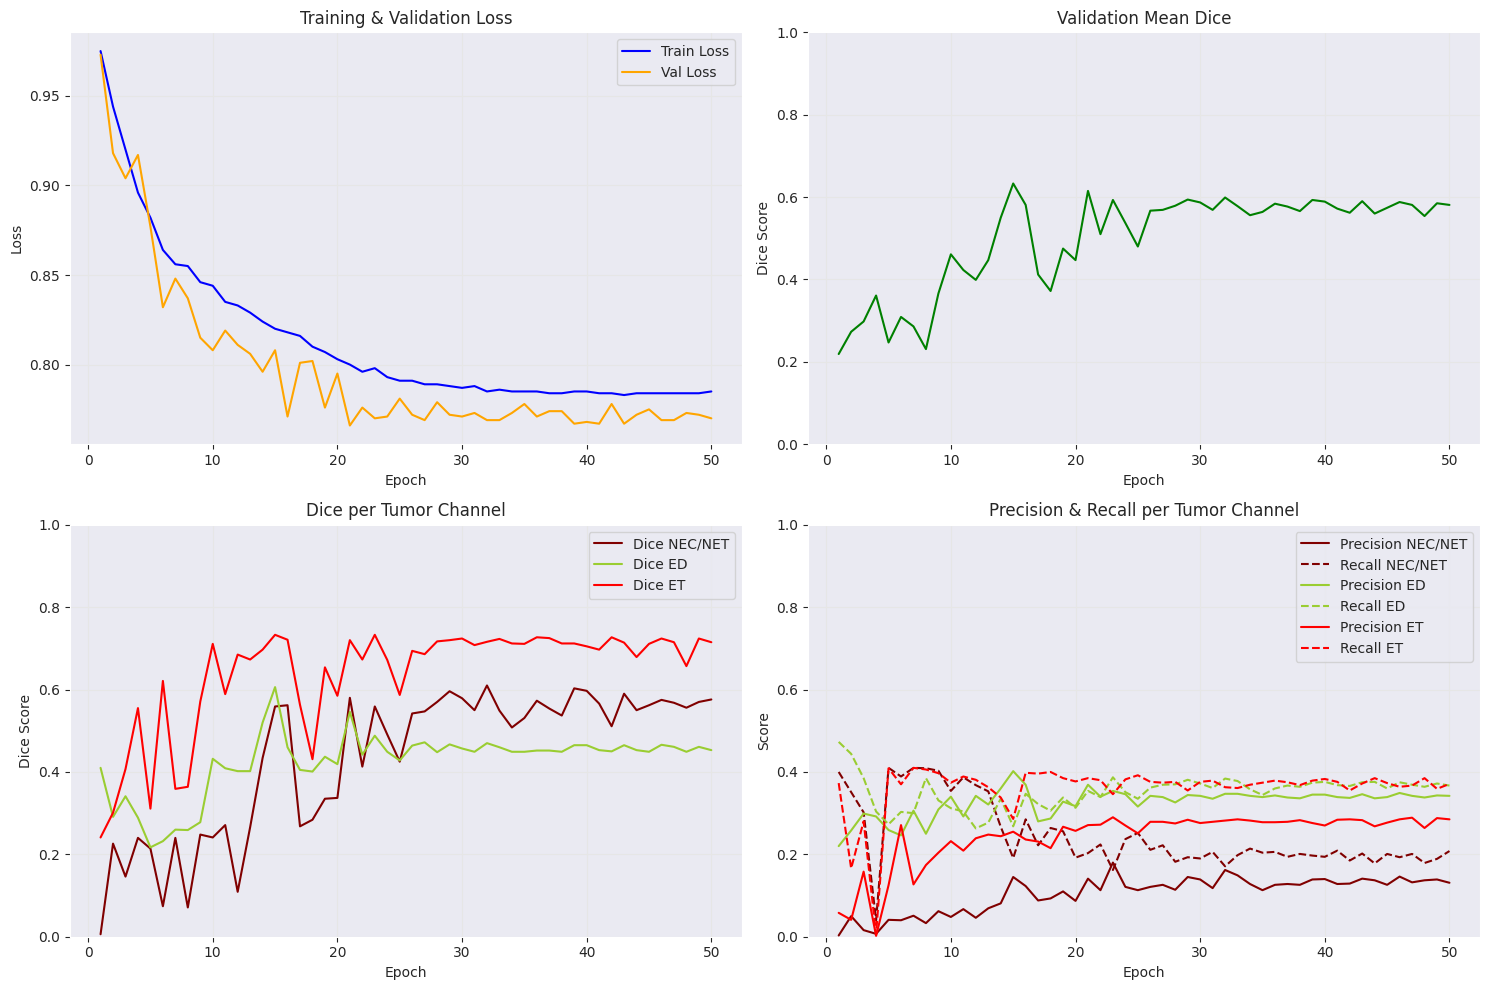

In [44]:
channel_colors = ['maroon', 'yellowgreen', 'red']
channel_names  = ['NEC/NET', 'ED', 'ET']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()  # easier indexing

# Training & Validation Loss
axes[0].plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss', color='blue', marker='')
axes[0].plot(metrics_df['epoch'], metrics_df['val_loss'], label='Val Loss', color='orange', marker='')
axes[0].set_title('Training & Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Mean Dice
axes[1].plot(metrics_df['epoch'], metrics_df['mean_dice'], label='Mean Dice', color='green', marker='')
axes[1].set_title('Validation Mean Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_ylim(0, 1)
axes[1].grid(True)

# Dice per channel
for i, ch in enumerate(channel_names):
    axes[2].plot(metrics_df['epoch'], metrics_df[f'dice_{ch}'], label=f'Dice {ch}', color=channel_colors[i], marker='')
axes[2].set_title('Dice per Tumor Channel')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Dice Score')
axes[2].set_ylim(0, 1)
axes[2].legend()
axes[2].grid(True)

# Precision & Recall per channel
for i, ch in enumerate(channel_names):
    axes[3].plot(metrics_df['epoch'], metrics_df[f'prec_{ch}'], label=f'Precision {ch}', color=channel_colors[i], marker='', linestyle='-')
    axes[3].plot(metrics_df['epoch'], metrics_df[f'recall_{ch}'], label=f'Recall {ch}', color=channel_colors[i], marker='', linestyle='--')
axes[3].set_title('Precision & Recall per Tumor Channel')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Score')
axes[3].set_ylim(0, 1)
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

Based on the above, the metrics seemed to stabilize starting between epoch 20-30. Therefore, an improved modeling architecture is necessary to see a better model performance.

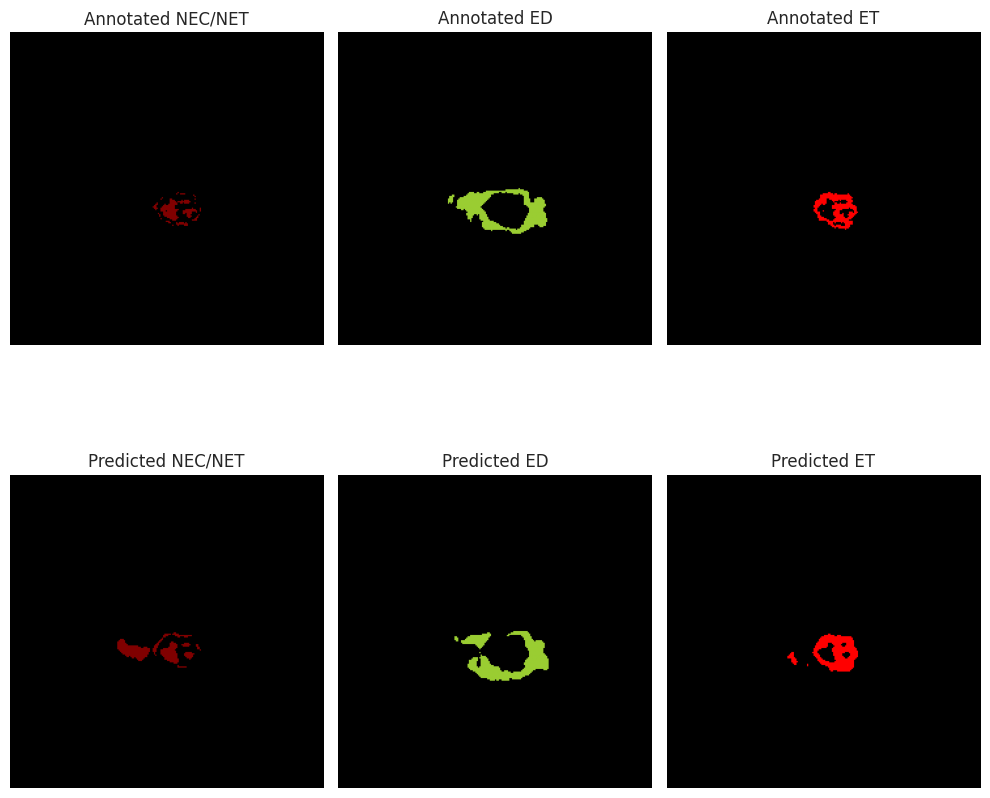

In [36]:
# Select a specific validation slice
slice_index = 33

image, mask = val_dataset[slice_index]

# Add batch dimension (model expects B,C,H,W)
image = image.unsqueeze(0).to(device)
mask = mask.unsqueeze(0).to(device)

# Set model to eval mode
model.eval()

with torch.no_grad():
    output = model(image)
    probs = torch.sigmoid(output)
    pred = (probs > 0.5).float()

# Move everything to CPU for plotting
image = image.cpu()
mask = mask.cpu()
pred = pred.cpu()

# Remove batch dimension for plotting
image = image[0]
mask = mask[0]
pred = pred[0]

# Set up figure
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

# Iterable colors and plot titles
channel_colors = ['maroon', 'yellowgreen', 'red']
actual_titles = ['Annotated NEC/NET', 'Annotated ED', 'Annotated ET']
pred_titles = ['Predicted NEC/NET', 'Predicted ED', 'Predicted ET']

# Ground Truth
for c in range(3):
    annotated_cmap = ListedColormap(['black', channel_colors[c]])
    axes[0, c].imshow(mask[c], cmap=annotated_cmap, vmin=0, vmax=1)
    axes[0, c].set_title(actual_titles[c])
    axes[0, c].axis('off')

# Predictions
for c in range(3):
    pred_cmap = ListedColormap(['black', channel_colors[c]])
    axes[1, c].imshow(pred[c], cmap=pred_cmap, vmin=0, vmax=1)
    axes[1, c].set_title(pred_titles[c])
    axes[1, c].axis('off')

plt.tight_layout()
plt.show()

---

## Conclusions

---

This baseline version implemented a multi-class brain tumor segmentation pipeline trained with Dice loss, achieving a mean validation Dice score of 0.58. Performance varied across tumor subregions, with enhancing tumor (ET) segmented more reliably than necrotic and edema regions, which is an expected pattern given class imbalance and irregular boundaries.

Visual evaluation revealed extensive slice-to-slice variability. Some predictions exceeded what the average Dice score suggests, while others fell short, reinforcing the need to assess both quantitative and qualitative results in medical imaging tasks.

Several improvements could strengthen this baseline for future versions:

- **Class imbalance handling:** weighted Dice, hybrid Dice + BCE, focal loss, or foreground-aware sampling
- **3D context modeling:** 2.5D inputs or full 3D U-Net architectures
- **Stronger augmentation:** elastic deformations, affine transforms, intensity shifts
- **Architectural upgrades:** attention mechanisms, residual backbones, pretrained encoders
- **Post-processing:** connected-component filtering to reduce false positives
- **Cross-validation:** more reliable performance estimation across folds

Overall, this notebook establishes a clean, reproducible baseline with a reliable training and evaluation pipeline. While performance could be better, the structure is robust and ready for improved iterations.